# Import Necessary Libraries

In [132]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [133]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Austin/2021/austin_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5456,2022-03-13,f,$250.00,$250.00,2.0,90.0
1,5456,2022-03-14,f,$250.00,$250.00,2.0,90.0
2,5456,2022-03-15,f,$250.00,$250.00,2.0,90.0
3,5456,2022-03-16,f,$250.00,$250.00,2.0,90.0
4,5456,2022-03-17,t,$250.00,$250.00,2.0,90.0
...,...,...,...,...,...,...,...
4369412,580590011933192873,2023-03-07,f,"$10,000.00","$10,000.00",3.0,365.0
4369413,580590011933192873,2023-03-08,f,"$10,000.00","$10,000.00",3.0,365.0
4369414,580590011933192873,2023-03-09,f,"$10,000.00","$10,000.00",3.0,365.0
4369415,580590011933192873,2023-03-10,f,"$10,000.00","$10,000.00",3.0,365.0


In [134]:
#Check the info / types of data
raw_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369417 entries, 0 to 4369416
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 233.4+ MB


In [135]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369417 entries, 0 to 4369416
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 233.4+ MB


In [136]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2022-03-12 00:00:00
Latest date of data set 2023-03-30 00:00:00


In [137]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

f    2706886
t    1662531
Name: available, dtype: int64

In [138]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

0    2706886
1    1662531
Name: available, dtype: int64

In [139]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369417 entries, 0 to 4369416
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 233.4+ MB


In [140]:
mod_calendar_data['price'].value_counts()

$150.00      119478
$200.00      101231
$100.00       88146
$250.00       86513
$300.00       75361
              ...  
$4,915.00         1
$2,640.00         1
$2,904.00         1
$3,053.00         1
$4,585.00         1
Name: price, Length: 4240, dtype: int64

In [141]:
mod_calendar_data['price'].isna().sum()

168

In [142]:
mod_calendar_data['adjusted_price'].value_counts()

$150.00      116805
$200.00      100565
$100.00       86853
$250.00       84880
$300.00       74372
              ...  
$3,838.00         1
$3,779.00         1
$3,567.00         1
$4,129.00         1
$4,820.00         1
Name: adjusted_price, Length: 4235, dtype: int64

In [143]:
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

43611005    168
Name: listing_id, dtype: int64

In [144]:
bnb_to_drop = mod_calendar_data[(mod_calendar_data['listing_id'] == 43611005)].index
mod_calendar_data = mod_calendar_data.drop(bnb_to_drop)
mod_calendar_data['price'].isna().sum()

0

In [145]:
mod_calendar_data['price']

0             $250.00
1             $250.00
2             $250.00
3             $250.00
4             $250.00
              ...    
4369412    $10,000.00
4369413    $10,000.00
4369414    $10,000.00
4369415    $10,000.00
4369416    $10,000.00
Name: price, Length: 4369052, dtype: object

In [146]:
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_6053/3964135494.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,5456,250,2022-03-13,0,2.0,90.0
1,5456,250,2022-03-14,0,2.0,90.0
2,5456,250,2022-03-15,0,2.0,90.0
3,5456,250,2022-03-16,0,2.0,90.0
4,5456,250,2022-03-17,1,2.0,90.0
...,...,...,...,...,...,...
4369412,580590011933192873,10000,2023-03-07,0,3.0,365.0
4369413,580590011933192873,10000,2023-03-08,0,3.0,365.0
4369414,580590011933192873,10000,2023-03-09,0,3.0,365.0
4369415,580590011933192873,10000,2023-03-10,0,3.0,365.0


In [147]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4369052 entries, 0 to 4369416
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   daily_price     int64         
 2   date            datetime64[ns]
 3   available       int64         
 4   minimum_nights  float64       
 5   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 362.3 MB


In [148]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

In [149]:
#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4369052 entries, 0 to 4369416
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   listing_id   int64         
 1   daily_price  int64         
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 262.3 MB


In [150]:
# mod_calendar_data_id_avail = mod_calendar_data.groupby(['listing_id']).sum()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.reset_index()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['price'], axis = 1)
# mod_calendar_data_id_avail['perc_year_avail'] = mod_calendar_data_id_avail['available'] / 365
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['available'], axis = 1)
# mod_calendar_data_id_avail

In [151]:
# mod_calendar_data_id_avail.info()

## Listings Data - 2022

In [152]:
raw_listings_data = pd.read_csv('../Data/AirBnB/Austin/2021/austin_listings_2021.csv')
raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20220312074014,2022-03-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,...,4.81,4.73,4.78,NaN,f,1,1,0,0,3.69
1,5769,https://www.airbnb.com/rooms/5769,20220312074014,2022-03-31,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,...,4.94,4.74,4.92,NaN,f,1,0,1,0,1.81
2,6413,https://www.airbnb.com/rooms/6413,20220312074014,2022-03-31,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,https://www.airbnb.com/users/show/13879,...,4.98,4.86,4.94,NaN,t,1,1,0,0,0.78
3,6448,https://www.airbnb.com/rooms/6448,20220312074014,2022-03-12,"Secluded Studio @ Zilker - King Bed, Bright & ...","Clean, private space with everything you need ...",The neighborhood is fun and funky (but quiet)!...,https://a0.muscache.com/pictures/4513152/4ffc1...,14156,https://www.airbnb.com/users/show/14156,...,4.97,4.97,4.89,NaN,t,1,1,0,0,2.09
4,8502,https://www.airbnb.com/rooms/8502,20220312074014,2022-03-13,Woodland Studio Lodging,<b>The space</b><br />Fully furnished suite wi...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,25298,https://www.airbnb.com/users/show/25298,...,4.86,4.64,4.57,NaN,f,1,1,0,0,0.33


In [153]:
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11972 non-null  int64  
 1   listing_url                                   11972 non-null  object 
 2   scrape_id                                     11972 non-null  int64  
 3   last_scraped                                  11972 non-null  object 
 4   name                                          11972 non-null  object 
 5   description                                   11808 non-null  object 
 6   neighborhood_overview                         7059 non-null   object 
 7   picture_url                                   11971 non-null  object 
 8   host_id                                       11972 non-null  int64  
 9   host_url                                      11972 non-null 

In [154]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [155]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [156]:
#Remove

mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [157]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11972 non-null  int64  
 1   listing_url             11972 non-null  object 
 2   name                    11972 non-null  object 
 3   picture_url             11971 non-null  object 
 4   host_id                 11972 non-null  int64  
 5   host_url                11972 non-null  object 
 6   host_is_superhost       11969 non-null  object 
 7   host_identity_verified  11969 non-null  object 
 8   neighbourhood           7059 non-null   object 
 9   latitude                11972 non-null  float64
 10  longitude               11972 non-null  float64
 11  room_type               11972 non-null  object 
 12  accommodates            11972 non-null  int64  
 13  bathrooms_text          11956 non-null  object 
 14  bedrooms                11261 non-null

In [158]:
#Fill the missing neighborhood data with 'Austin, Texas, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Austin, Texas, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [159]:
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2, 3], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11972 non-null  int64  
 1   listing_url             11972 non-null  object 
 2   name                    11972 non-null  object 
 3   picture_url             11971 non-null  object 
 4   host_id                 11972 non-null  int64  
 5   host_url                11972 non-null  object 
 6   host_is_superhost       11969 non-null  object 
 7   host_identity_verified  11969 non-null  object 
 8   latitude                11972 non-null  float64
 9   longitude               11972 non-null  float64
 10  room_type               11972 non-null  object 
 11  accommodates            11972 non-null  int64  
 12  bathrooms_text          11956 non-null  object 
 13  bedrooms                11261 non-null  float64
 14  beds                    11822 non-null

In [160]:
mod_listing_data['neighborhood'].value_counts()

Austin              11859
Lakeway                29
West Lake Hills        14
Dripping Springs       14
Sunset Valley           8
Manchaca                6
Round Rock              5
Leander                 5
Pflugerville            4
The Hills               4
Del Valle               3
Bee Cave                3
Buda                    2
Cedar Park              2
Lago Vista              2
Manor                   2
Austin                  2
Westlake Hills          1
Bouldin                 1
Rollingwood             1
Clarksville             1
United States           1
Lake Travis             1
Volente                 1
Travis County           1
Name: neighborhood, dtype: int64

In [161]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Austin '],['Austin'])

neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] != 'Austin')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

In [162]:
mod_listing_data['neighborhood'].value_counts()

Austin    11861
Name: neighborhood, dtype: int64

In [163]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text'], axis = 0)

In [164]:
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         2
host_identity_verified    2
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [165]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

0.0    4941
1.0    3314
Name: host_is_superhost, dtype: int64

In [166]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1.0    6992
0.0    1263
Name: host_identity_verified, dtype: int64

In [167]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

0    4878
1    3379
Name: instant_bookable, dtype: int64

In [168]:
mod_listing_data['neighborhood'].value_counts()

Austin    8257
Name: neighborhood, dtype: int64

In [169]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath               3419
2 baths              1839
2.5 baths             670
1 shared bath         535
1 private bath        466
1.5 baths             418
3 baths               365
3.5 baths             142
1.5 shared baths      120
4 baths                99
4.5 baths              52
5 baths                30
2 shared baths         21
5.5 baths              12
6.5 baths              11
2.5 shared baths       10
6 baths                 9
3 shared baths          9
0 baths                 7
0 shared baths          5
7.5 baths               4
Half-bath               4
7 baths                 2
8 baths                 2
4 shared baths          2
17 baths                1
10.5 baths              1
8.5 baths               1
Private half-bath       1
Name: bathrooms_text, dtype: int64

In [170]:
mod_listing_data['instant_bookable'].value_counts()

0    4878
1    3379
Name: instant_bookable, dtype: int64

In [171]:
mod_listing_data['beds'].value_counts()

1.0     2835
2.0     2218
3.0     1436
4.0      701
5.0      346
6.0      228
7.0      145
8.0      102
9.0       57
10.0      51
11.0      31
12.0      28
14.0      21
13.0      18
15.0      11
16.0      10
18.0       5
17.0       4
22.0       3
20.0       2
36.0       1
39.0       1
61.0       1
26.0       1
19.0       1
Name: beds, dtype: int64

In [172]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8257 entries, 0 to 11879
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      8257 non-null   int64  
 1   listing_url             8257 non-null   object 
 2   name                    8257 non-null   object 
 3   picture_url             8257 non-null   object 
 4   host_id                 8257 non-null   int64  
 5   host_url                8257 non-null   object 
 6   host_is_superhost       8255 non-null   float64
 7   host_identity_verified  8255 non-null   float64
 8   latitude                8257 non-null   float64
 9   longitude               8257 non-null   float64
 10  room_type               8257 non-null   object 
 11  accommodates            8257 non-null   int64  
 12  bathrooms_text          8257 non-null   object 
 13  bedrooms                8257 non-null   float64
 14  beds                    8257 non-null  

In [173]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [174]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath               3419
2 baths              1839
2.5 baths             670
1 shared bath         535
1 private bath        466
1.5 baths             418
3 baths               365
3.5 baths             142
1.5 shared baths      120
4 baths                99
4.5 baths              52
5 baths                30
2 shared baths         21
5.5 baths              12
6.5 baths              11
2.5 shared baths       10
6 baths                 9
3 shared baths          9
0 baths                 7
0 shared baths          5
7.5 baths               4
Half-bath               4
7 baths                 2
8 baths                 2
4 shared baths          2
17 baths                1
10.5 baths              1
8.5 baths               1
Private half-bath       1
Name: bathrooms_text, dtype: int64

In [175]:
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [176]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [177]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              3419
2 baths             1839
2.5 baths            670
1 shared bath        535
1 private bath       466
1.5 baths            418
3 baths              365
3.5 baths            142
1.5 shared baths     120
4 baths               99
4.5 baths             52
5 baths               30
2 shared baths        21
5.5 baths             12
6.5 baths             11
2.5 shared baths      10
6 baths                9
3 shared baths         9
0 baths                7
0 shared baths         5
0.5                    5
7.5 baths              4
7 baths                2
8 baths                2
4 shared baths         2
17 baths               1
10.5 baths             1
8.5 baths              1
Name: bathrooms_text, dtype: int64

In [178]:
# mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].str.split(" ", n = 1, expand = True)

test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8257 entries, 0 to 11879
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      8257 non-null   int64  
 1   listing_url             8257 non-null   object 
 2   name                    8257 non-null   object 
 3   picture_url             8257 non-null   object 
 4   host_id                 8257 non-null   int64  
 5   host_url                8257 non-null   object 
 6   host_is_superhost       8255 non-null   float64
 7   host_identity_verified  8255 non-null   float64
 8   latitude                8257 non-null   float64
 9   longitude               8257 non-null   float64
 10  room_type               8257 non-null   object 
 11  accommodates            8257 non-null   int64  
 12  bedrooms                8257 non-null   float64
 13  beds                    8257 non-null   float64
 14  amenities               8257 non-null  

In [179]:
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']

In [180]:
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [181]:
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])

In [182]:
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [183]:
mod_listing_data['listing_id'] = mod_listing_data['id']
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8257 entries, 0 to 11879
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              8257 non-null   int64  
 1   listing_url             8257 non-null   object 
 2   name                    8257 non-null   object 
 3   picture_url             8257 non-null   object 
 4   host_id                 8257 non-null   int64  
 5   host_url                8257 non-null   object 
 6   host_is_superhost       8255 non-null   float64
 7   host_identity_verified  8255 non-null   float64
 8   latitude                8257 non-null   float64
 9   longitude               8257 non-null   float64
 10  room_type               8257 non-null   object 
 11  accommodates            8257 non-null   int64  
 12  bedrooms                8257 non-null   float64
 13  beds                    8257 non-null   float64
 14  minimum_nights          8257 non-null  

## Combine Calendar Data and Listings Data

In [184]:
mod_calendar_data

,listing_id,daily_price,date
0,5456,250,2022-03-13
1,5456,250,2022-03-14
2,5456,250,2022-03-15
3,5456,250,2022-03-16
4,5456,250,2022-03-17
...,...,...,...
4369412,580590011933192873,10000,2023-03-07
4369413,580590011933192873,10000,2023-03-08
4369414,580590011933192873,10000,2023-03-09
4369415,580590011933192873,10000,2023-03-10


In [185]:
mod_calendar_data['listing_id']

0                        5456
1                        5456
2                        5456
3                        5456
4                        5456
                  ...        
4369412    580590011933192873
4369413    580590011933192873
4369414    580590011933192873
4369415    580590011933192873
4369416    580590011933192873
Name: listing_id, Length: 4369052, dtype: int64

In [186]:
print(mod_listing_data.columns)
mod_calendar_data.columns

Index(['listing_id', 'listing_url', 'name', 'picture_url', 'host_id',
       'host_url', 'host_is_superhost', 'host_identity_verified', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'neighborhood', 'bathrooms',
       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer',
       'Heating'],
      dtype='object')


Index(['listing_id', 'daily_price', 'date'], dtype='object')

In [187]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4369052 entries, 0 to 4369416
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   listing_id   int64         
 1   daily_price  int64         
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 262.3 MB


In [188]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8257 entries, 0 to 11879
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              8257 non-null   int64  
 1   listing_url             8257 non-null   object 
 2   name                    8257 non-null   object 
 3   picture_url             8257 non-null   object 
 4   host_id                 8257 non-null   int64  
 5   host_url                8257 non-null   object 
 6   host_is_superhost       8255 non-null   float64
 7   host_identity_verified  8255 non-null   float64
 8   latitude                8257 non-null   float64
 9   longitude               8257 non-null   float64
 10  room_type               8257 non-null   object 
 11  accommodates            8257 non-null   int64  
 12  bedrooms                8257 non-null   float64
 13  beds                    8257 non-null   float64
 14  minimum_nights          8257 non-null  

### Drop Outliers

In [189]:
austin_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')
austin_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3013807 entries, 0 to 3013806
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [190]:
austin_data = austin_data.dropna()

In [191]:
austin_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3013077 entries, 0 to 3013806
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [192]:
austin_data['date'].value_counts()

2022-09-21    8255
2022-10-26    8255
2022-11-03    8255
2022-11-02    8255
2022-11-01    8255
              ... 
2023-03-19    2269
2023-03-18    2269
2023-03-17    2269
2023-03-16    2269
2023-03-13    2269
Name: date, Length: 384, dtype: int64

In [193]:
austin_data['date'] = austin_data['date'].replace(['2022-12-15'],['2021-12-15'])
austin_data['date'] = austin_data['date'].replace(['2022-12-16'],['2021-12-16'])
austin_data['date'] = austin_data['date'].replace(['2022-12-17'],['2021-12-17'])

In [194]:
austin_data = austin_data[austin_data['bathrooms'] <= 6]
austin_data = austin_data[austin_data['bathrooms'] >= 1]

austin_data = austin_data[austin_data['bedrooms'] <= 6]
austin_data = austin_data[austin_data['beds'] <= 11]
austin_data = austin_data[austin_data['bathrooms'] <= 5]

austin_data = austin_data[austin_data['room_type'] != 'Hotel room']
austin_data = austin_data[austin_data['room_type'] != 'Shared room']

austin_data = austin_data[austin_data['daily_price'] <= 1000]

In [195]:
austin_data = austin_data.reset_index()
austin_data = austin_data.drop(['index'], axis = 1)

In [196]:
austin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814927 entries, 0 to 2814926
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [197]:
graphing_one_bnb = austin_data[366:650]
graphing_one_bnb

,listing_id,listing_url,name,picture_url,host_id,host_url,host_is_superhost,host_identity_verified,latitude,longitude,...,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,date
366,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,50,2022-04-01
367,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,50,2022-04-02
368,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,39,2022-04-03
369,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,39,2022-04-04
370,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,39,2022-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,40,2023-01-05
646,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,41,2023-01-06
647,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,41,2023-01-07
648,5769,https://www.airbnb.com/rooms/5769,NW Austin Room,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,1.0,1.0,30.45697,-97.78422,...,1.0,1,1,1,1,0,1,1,41,2023-01-08


In [198]:
from geopy.distance import geodesic


origin = (30.172705, 31.526725)  # (latitude, longitude) don't confuse
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613
print(geodesic(origin, dist).miles)

23576.805481751613
23.576805481751613
14.64994773134371


In [199]:
austin_data['coords'] = list(zip(austin_data['latitude'],austin_data['longitude']))


falls_park = (30.183392637834487, -97.72267422932967) 
downtown = (30.273273348730932, -97.74476987419511)
capitol = (30.27482266440739, -97.74030758049228)

for idx, coords in enumerate(austin_data['coords']):
        austin_data.loc[idx,'distance_to_falls_park'] = geodesic(coords, falls_park).miles
        austin_data.loc[idx,'distance_to_downtown'] = geodesic(coords, downtown).miles
        austin_data.loc[idx,'distance_to_capitol'] = geodesic(coords, capitol).miles
    

In [200]:
austin_data

,listing_id,listing_url,name,picture_url,host_id,host_url,host_is_superhost,host_identity_verified,latitude,longitude,...,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_falls_park,distance_to_downtown,distance_to_capitol
0,5456,https://www.airbnb.com/rooms/5456,"Walk to 6th, Rainey St and Convention Ctr",https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,1.0,1.0,30.260570,-97.734410,...,1,0,0,1,250,2022-03-13,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
1,5456,https://www.airbnb.com/rooms/5456,"Walk to 6th, Rainey St and Convention Ctr",https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,1.0,1.0,30.260570,-97.734410,...,1,0,0,1,250,2022-03-14,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
2,5456,https://www.airbnb.com/rooms/5456,"Walk to 6th, Rainey St and Convention Ctr",https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,1.0,1.0,30.260570,-97.734410,...,1,0,0,1,250,2022-03-15,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
3,5456,https://www.airbnb.com/rooms/5456,"Walk to 6th, Rainey St and Convention Ctr",https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,1.0,1.0,30.260570,-97.734410,...,1,0,0,1,250,2022-03-16,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
4,5456,https://www.airbnb.com/rooms/5456,"Walk to 6th, Rainey St and Convention Ctr",https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,1.0,1.0,30.260570,-97.734410,...,1,0,0,1,250,2022-03-17,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2814922,577596199055496685,https://www.airbnb.com/rooms/577596199055496685,Spacious 1-bedroom - only 7 minutes from downt...,https://a0.muscache.com/pictures/miso/Hosting-...,50003778,https://www.airbnb.com/users/show/50003778,0.0,1.0,30.331875,-97.689227,...,1,0,0,0,159,2023-03-07,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575
2814923,577596199055496685,https://www.airbnb.com/rooms/577596199055496685,Spacious 1-bedroom - only 7 minutes from downt...,https://a0.muscache.com/pictures/miso/Hosting-...,50003778,https://www.airbnb.com/users/show/50003778,0.0,1.0,30.331875,-97.689227,...,1,0,0,0,159,2023-03-08,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575
2814924,577596199055496685,https://www.airbnb.com/rooms/577596199055496685,Spacious 1-bedroom - only 7 minutes from downt...,https://a0.muscache.com/pictures/miso/Hosting-...,50003778,https://www.airbnb.com/users/show/50003778,0.0,1.0,30.331875,-97.689227,...,1,0,0,0,159,2023-03-09,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575
2814925,577596199055496685,https://www.airbnb.com/rooms/577596199055496685,Spacious 1-bedroom - only 7 minutes from downt...,https://a0.muscache.com/pictures/miso/Hosting-...,50003778,https://www.airbnb.com/users/show/50003778,0.0,1.0,30.331875,-97.689227,...,1,0,0,0,199,2023-03-10,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575


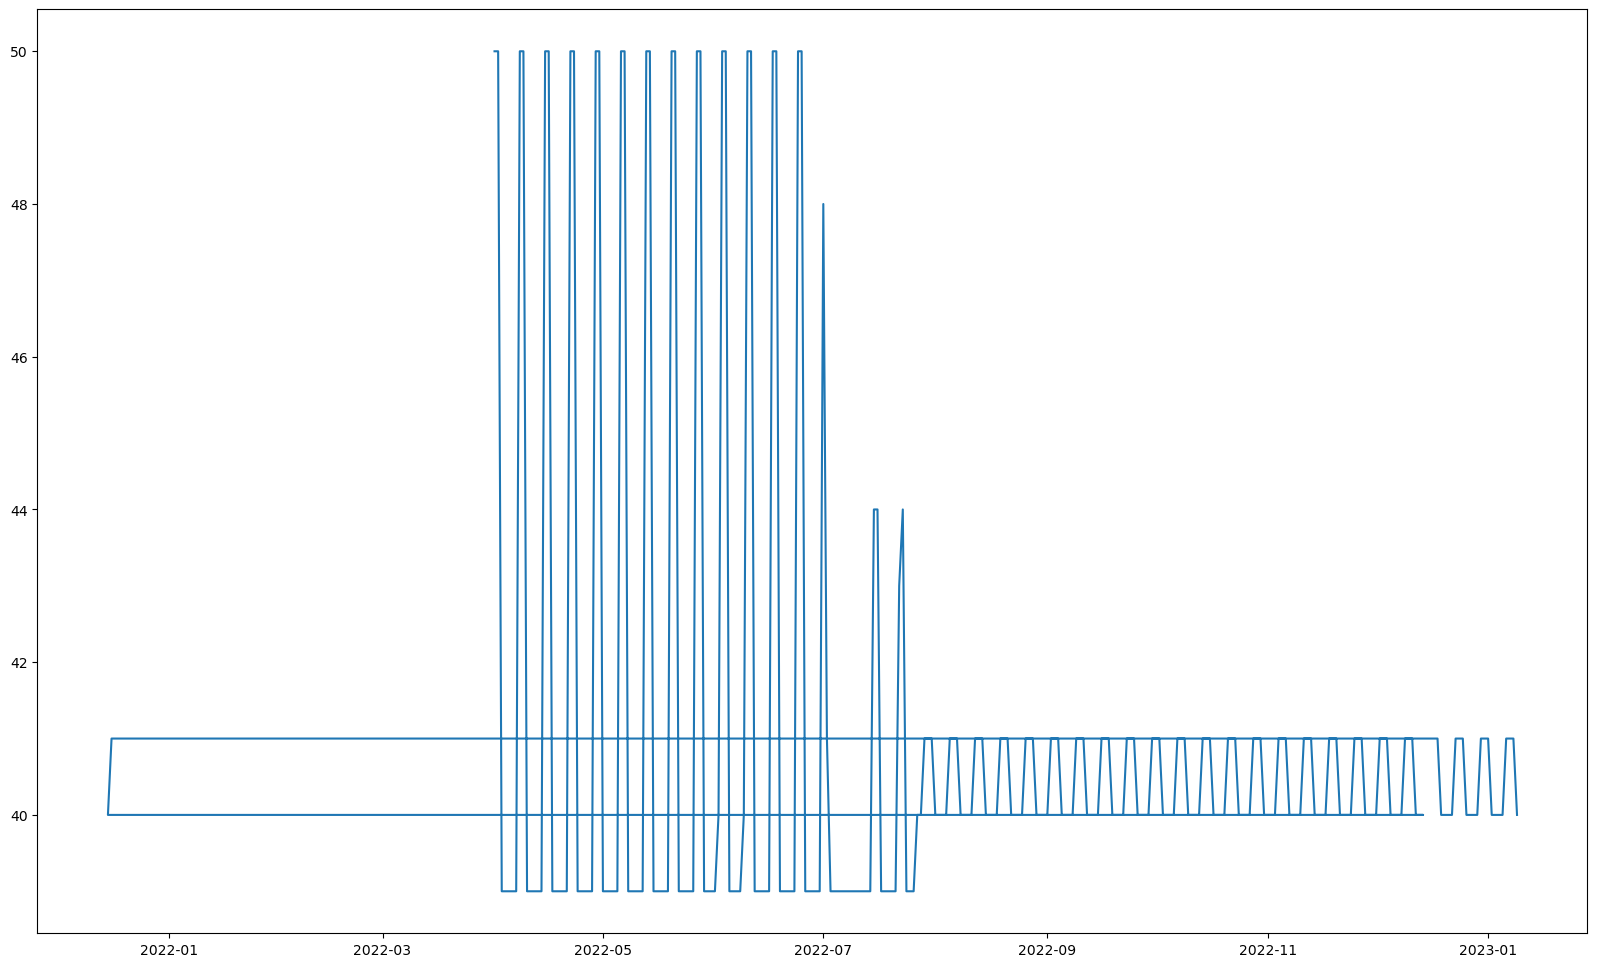

In [201]:
graphing_one_bnb = austin_data[366:650]
y_graphing_one_bnb = graphing_one_bnb['daily_price']
x_graphing_one_bnb = graphing_one_bnb['date']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(x_graphing_one_bnb, y_graphing_one_bnb)
plt.show()

# fig = plt.figure()
# ax = plt.axes()

# ax.plot(x_graphing_one_bnb, y_graphing_one_bnb);

In [202]:
austin_modeling_data = austin_data.drop(['listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
austin_modeling_data.head()

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,...,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_falls_park,distance_to_downtown,distance_to_capitol
0,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-13,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
1,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-14,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
2,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-15,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
3,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-16,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
4,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-17,"(30.26057, -97.73441)",5.362349,1.072111,1.043179


In [203]:
austin_modeling_data['neighborhood'].value_counts()

Austin    2814927
Name: neighborhood, dtype: int64

In [204]:
austin_modeling_data['day_of_week'] = austin_modeling_data['date'].dt.dayofweek
austin_modeling_data['month'] = austin_modeling_data['date'].dt.month
austin_modeling_data['week'] = austin_modeling_data['date'].dt.week
austin_modeling_data = austin_modeling_data.drop(['date'], axis = 1)
austin_modeling_data.info()

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_6053/2372679271.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  austin_modeling_data['week'] = austin_modeling_data['date'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814927 entries, 0 to 2814926
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   listing_id              int64  
 1   host_is_superhost       float64
 2   room_type               object 
 3   accommodates            int64  
 4   bedrooms                float64
 5   beds                    float64
 6   neighborhood            object 
 7   bathrooms               float64
 8   Air conditioning        int64  
 9   Wifi                    int64  
 10  TV                      int64  
 11  Kitchen                 int64  
 12  Washer                  int64  
 13  Dryer                   int64  
 14  Heating                 int64  
 15  daily_price             int64  
 16  coords                  object 
 17  distance_to_falls_park  float64
 18  distance_to_downtown    float64
 19  distance_to_capitol     float64
 20  day_of_week             int64  
 21  month                   int64  

In [205]:
austin_modeling_data['room_type'].value_counts()

Entire home/apt    2309297
Private room        505630
Name: room_type, dtype: int64

In [206]:
austin_modeling_data['Heating'].value_counts()

1    2277520
0     537407
Name: Heating, dtype: int64

In [207]:
austin_modeling_data.describe()

,listing_id,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,distance_to_falls_park,distance_to_downtown,distance_to_capitol,day_of_week,month,week
count,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06,2.814927e+06
mean,1.787113e+16,4.069644e-01,4.616513e+00,1.884627e+00,2.436877e+00,1.529462e+00,9.145260e-01,9.556770e-01,8.948786e-01,9.161474e-01,7.268398e-01,6.533740e-01,8.090867e-01,2.261362e+02,7.827548e+00,4.385662e+00,4.390711e+00,2.986920e+00,6.523579e+00,2.644573e+01
std,9.777467e+16,4.912682e-01,2.720239e+00,1.027034e+00,1.695252e+00,6.964731e-01,2.795858e-01,2.058118e-01,3.067098e-01,2.771667e-01,4.455825e-01,4.758955e-01,3.930209e-01,1.886621e+02,4.327597e+00,3.690027e+00,3.701320e+00,2.000147e+00,3.439584e+00,1.497326e+01
min,5.456000e+03,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.716851e-01,8.388630e-02,2.453208e-01,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.743794e+07,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,9.900000e+01,5.003511e+00,1.828344e+00,1.793035e+00,1.000000e+00,4.000000e+00,1.300000e+01
50%,3.431239e+07,0.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.660000e+02,6.348737e+00,3.083741e+00,3.077105e+00,3.000000e+00,7.000000e+00,2.600000e+01
75%,4.968866e+07,1.000000e+00,6.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.900000e+02,9.319111e+00,5.878103e+00,5.837600e+00,5.000000e+00,1.000000e+01,3.900000e+01
max,5.775962e+17,1.000000e+00,1.600000e+01,6.000000e+00,1.100000e+01,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+03,2.266758e+01,1.879775e+01,1.908102e+01,6.000000e+00,1.200000e+01,5.200000e+01


In [208]:
austin_modeling_data

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,...,Dryer,Heating,daily_price,coords,distance_to_falls_park,distance_to_downtown,distance_to_capitol,day_of_week,month,week
0,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,0,1,250,"(30.26057, -97.73441)",5.362349,1.072111,1.043179,6,3,10
1,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,0,1,250,"(30.26057, -97.73441)",5.362349,1.072111,1.043179,0,3,11
2,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,0,1,250,"(30.26057, -97.73441)",5.362349,1.072111,1.043179,1,3,11
3,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,0,1,250,"(30.26057, -97.73441)",5.362349,1.072111,1.043179,2,3,11
4,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,0,1,250,"(30.26057, -97.73441)",5.362349,1.072111,1.043179,3,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2814922,577596199055496685,0.0,Entire home/apt,5,1.0,3.0,Austin,1.0,0,1,...,0,0,159,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575,1,3,10
2814923,577596199055496685,0.0,Entire home/apt,5,1.0,3.0,Austin,1.0,0,1,...,0,0,159,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575,2,3,10
2814924,577596199055496685,0.0,Entire home/apt,5,1.0,3.0,Austin,1.0,0,1,...,0,0,159,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575,3,3,10
2814925,577596199055496685,0.0,Entire home/apt,5,1.0,3.0,Austin,1.0,0,1,...,0,0,199,"(30.331875102085267, -97.68922697313208)",10.421676,5.226514,4.976575,4,3,10


In [209]:
austin_modeling_data.columns

Index(['listing_id', 'host_is_superhost', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'neighborhood', 'bathrooms', 'Air conditioning',
       'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating', 'daily_price',
       'coords', 'distance_to_falls_park', 'distance_to_downtown',
       'distance_to_capitol', 'day_of_week', 'month', 'week'],
      dtype='object')

## Baseline Model - Neural Network

In [79]:
#One hot encode the categorical columns
baseline_model_sklearn = austin_modeling_data
baseline_model_cat = baseline_model_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(baseline_model_cat)

baseline_model_cat_ohe = pd.DataFrame(data = ohe.transform(baseline_model_cat),
                              columns = ohe.get_feature_names_out())
baseline_model_cat_ohe

,neighborhood_Asheville,neighborhood_Candler,neighborhood_Fletcher,neighborhood_Woodfin,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
811425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [80]:
#Merge the one hot encoded dataframe and the numeric columns
baseline_model_numeric = austin_modeling_data[['listing_id', 'daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'week']]

baseline_model_comb_ohe = baseline_model_numeric.join(baseline_model_cat_ohe, how = 'left')
# baseline_model_comb_ohe = baseline_model_comb_ohe.groupby(['listing_id', 'week']).mean()
# baseline_model_comb_ohe = baseline_model_comb_ohe.reset_index()
# baseline_model_comb_ohe = baseline_model_comb_ohe.drop(['week'], axis = 1)
baseline_model_comb_ohe


,listing_id,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,108061,120.0,0,2,1.0,1.0,1.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811422,53735375,165.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811423,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811424,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
811425,53735375,150.0,1,3,1.0,1.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [81]:
baseline_model_X = baseline_model_comb_ohe.drop(['daily_price', 'listing_id'], axis = 1)
baseline_model_y = baseline_model_comb_ohe['daily_price']

baseline_model_X_train, baseline_model_X_test, baseline_model_y_train, baseline_model_y_test = train_test_split(
                                                                                                baseline_model_X, 
                                                                                                baseline_model_y, 
                                                                                                test_size = 0.18)

baseline_model_X_train, baseline_model_X_val, baseline_model_y_train, baseline_model_y_val = train_test_split(
                                                                                                baseline_model_X_train, 
                                                                                                baseline_model_y_train,
                                                                                                test_size = 0.12)

#### Instantiate a new scaler
scaler = StandardScaler()

baseline_model_X_train_scaled = scaler.fit_transform(baseline_model_X_train)
baseline_model_X_test_scaled = scaler.transform(baseline_model_X_test)
baseline_model_X_val_scaled = scaler.transform(baseline_model_X_val)

In [82]:
#Consider adding a decaying learning rate

In [83]:
#Instantiate a Regularizer

reg = l2(3e-3)

baseline_model_nn = models.Sequential()
baseline_model_nn.add(layers.Flatten())
baseline_model_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
baseline_model_nn.add(layers.Dropout(0.5))
baseline_model_nn.add(layers.Dense(1))


#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
baseline_model_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
baseline_model_nn_histoire = baseline_model_nn.fit(baseline_model_X_train_scaled,
                                                   baseline_model_y_train.values,
                                                   callbacks = [es],
                                                   epochs = 50,
                                                   batch_size = 1000,
                                                   validation_data = (baseline_model_X_val_scaled, 
                                                                      baseline_model_y_val.values))

Metal device set to: Apple M1 Pro
Epoch 1/50


2022-12-31 15:48:43.251374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-31 15:48:43.251714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-31 15:48:43.420946: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/586 [..............................] - ETA: 2:53 - loss: 186.3624 - mse: 51380.7969 - mae: 186.2822

2022-12-31 15:48:43.589615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 191.1941 - mse: 56052.0352 - mae: 191.1088

2022-12-31 15:48:47.078170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 4s 6ms/step - loss: 191.1941 - mse: 56052.0352 - mae: 191.1088 - val_loss: 190.6135 - val_mse: 55689.2930 - val_mae: 190.5182
Epoch 2/50
586/586 [==============================] - 4s 6ms/step - loss: 189.3156 - mse: 55338.7344 - mae: 189.2027 - val_loss: 188.6012 - val_mse: 54933.5117 - val_mae: 188.4669
Epoch 3/50
586/586 [==============================] - 4s 6ms/step - loss: 187.1170 - mse: 54535.1758 - mae: 186.9547 - val_loss: 186.2506 - val_mse: 54074.6914 - val_mae: 186.0571
Epoch 4/50
586/586 [==============================] - 4s 6ms/step - loss: 184.5911 - mse: 53629.1875 - mae: 184.3609 - val_loss: 183.5658 - val_mse: 53112.4727 - val_mae: 183.2959
Epoch 5/50
586/586 [==============================] - 4s 6ms/step - loss: 181.6898 - mse: 52615.2070 - mae: 181.3752 - val_loss: 180.4460 - val_mse: 52006.8711 - val_mae: 180.0832
Epoch 6/50
586/586 [==============================] - 4s 6ms/step - loss: 178.2944 - mse: 51441.9062 - mae: 177

Epoch 47/50
586/586 [==============================] - 3s 6ms/step - loss: 92.8511 - mse: 17926.3301 - mae: 90.2999 - val_loss: 73.7275 - val_mse: 13303.3770 - val_mae: 71.1958
Epoch 48/50
586/586 [==============================] - 3s 6ms/step - loss: 92.6805 - mse: 17878.8887 - mae: 90.1675 - val_loss: 73.5620 - val_mse: 13265.7881 - val_mae: 71.0671
Epoch 49/50
586/586 [==============================] - 3s 6ms/step - loss: 92.4595 - mse: 17801.6680 - mae: 89.9832 - val_loss: 73.4056 - val_mse: 13221.6328 - val_mae: 70.9479
Epoch 50/50
586/586 [==============================] - 4s 6ms/step - loss: 92.4079 - mse: 17788.8027 - mae: 89.9694 - val_loss: 73.2851 - val_mse: 13199.3828 - val_mae: 70.8645


In [84]:
baseline_model_nn_results_train = baseline_model_nn.evaluate(baseline_model_X_train_scaled, 
                                                             baseline_model_y_train.values)
baseline_model_nn_results_test = baseline_model_nn.evaluate(baseline_model_X_test_scaled, 
                                                            baseline_model_y_test.values)

print(f'Baseline Model Neural Network Train Results: {baseline_model_nn_results_train}')
print(f'Baseline Model Neural Network Test Results: {baseline_model_nn_results_test}')

4565/4565 [==============================] - 18s 4ms/step - loss: 73.2107 - mse: 13119.3984 - mae: 70.7902
Baseline Model Neural Network Train Results: [73.26405334472656, 13205.9482421875, 70.84332275390625]
Baseline Model Neural Network Test Results: [73.21070098876953, 13119.3984375, 70.79022979736328]


In [85]:
baseline_model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 86)                0         
                                                                 
 dense (Dense)               (None, 16)                1392      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [86]:
baseline_model_nn_train_preds = baseline_model_nn.predict(baseline_model_X_train_scaled)
baseline_model_nn_test_preds = baseline_model_nn.predict(baseline_model_X_test_scaled)

2022-12-31 15:53:18.282987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


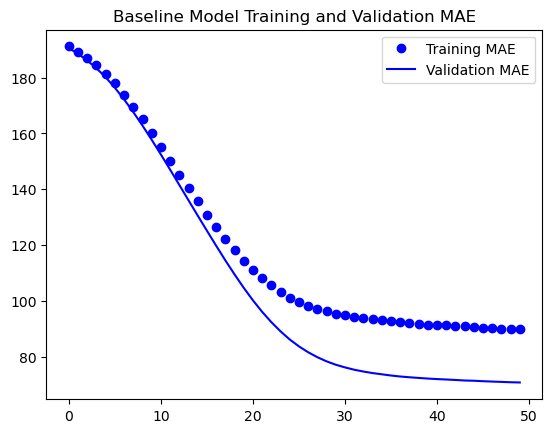

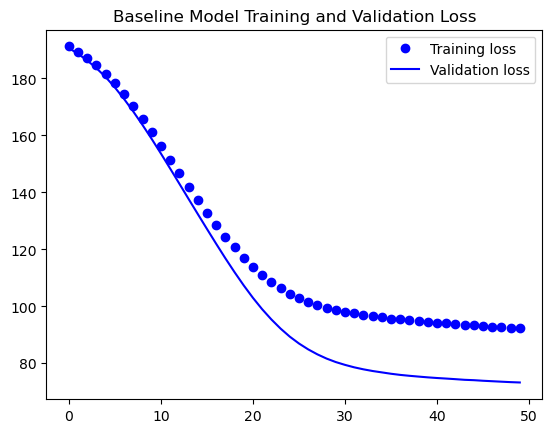

In [87]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
baseline_model_mae = baseline_model_nn_histoire.history['mae']
baseline_model_val_mae = baseline_model_nn_histoire.history['val_mae']
baseline_model_loss = baseline_model_nn_histoire.history['loss']
baseline_model_val_loss = baseline_model_nn_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_mae))

plt.plot(baseline_model_epochs, baseline_model_mae, 'bo', label = 'Training MAE')
plt.plot(baseline_model_epochs, baseline_model_val_mae, 'b', label = 'Validation MAE')
plt.title('Baseline Model Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();

In [88]:
print(f'Baseline Model train MAE w/ preds {mean_absolute_error(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model test MAE w/ preds {mean_absolute_error(baseline_model_y_test.values, baseline_model_nn_test_preds)}')

print(f'Baseline Model explained variance train score {explained_variance_score(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model explained variance test score {explained_variance_score(baseline_model_y_test.values, baseline_model_nn_test_preds)}')


print(f'Baseline Model test RMSE {mean_squared_error(baseline_model_y_test.values, baseline_model_nn_test_preds, squared = False)}')



Baseline Model train MAE w/ preds 70.8435896259606
Baseline Model test MAE w/ preds 70.79023437735648
Baseline Model explained variance train score 0.424983998399032
Baseline Model explained variance test score 0.42586089590496157
Baseline Model test RMSE 114.53990019566128


## Model 2 - Neural Network

In [89]:
#One hot encode the categorical columns
model2_sklearn = austin_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = austin_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'distance_to_biltmore', 'distance_to_downtown']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

In [90]:
#Begin modeling - set X and y variables
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

In [91]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.025)

In [92]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model
model2_nn = models.Sequential()
#Consider going bigger to smaller filters between conv1d layers
model2_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Dropout(0.4))
model2_nn.add(layers.Flatten())
## model2_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
## model2_nn.add(layers.Dropout(0.3))
# model2_nn.add(layers.Dense(64, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
# model2_nn.add(layers.Dense(32, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
# model2_nn.add(layers.Dropout(0.3))
model2_nn.add(layers.Dense(16, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.001, patience = 10)
early = [EarlyStopping(monitor='mae', min_delta = 0.001, patience = 20, mode = 'min'),
         ModelCheckpoint(filepath = 'austin_model2.h5', monitor = 'mae', save_best_only = True),
         LearningRateScheduler(scheduler)]

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 120,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

Epoch 1/120


2022-12-31 15:53:59.285535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - ETA: 0s - loss: 149.2529 - mse: 42549.0898 - mae: 149.1066

2022-12-31 15:54:10.677793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


586/586 [==============================] - 12s 20ms/step - loss: 149.2529 - mse: 42549.0898 - mae: 149.1066 - val_loss: 105.6517 - val_mse: 27926.4473 - val_mae: 105.4661
Epoch 2/120
586/586 [==============================] - 11s 19ms/step - loss: 85.4677 - mse: 19006.4688 - mae: 85.2583 - val_loss: 74.0643 - val_mse: 14740.6367 - val_mae: 73.8364
Epoch 3/120
586/586 [==============================] - 12s 20ms/step - loss: 73.3984 - mse: 13638.6992 - mae: 73.1597 - val_loss: 68.1082 - val_mse: 12107.2969 - val_mae: 67.8619
Epoch 4/120
586/586 [==============================] - 12s 20ms/step - loss: 70.0599 - mse: 12207.2139 - mae: 69.8103 - val_loss: 66.3654 - val_mse: 11332.8496 - val_mae: 66.1136
Epoch 5/120
586/586 [==============================] - 12s 21ms/step - loss: 68.8764 - mse: 11758.9551 - mae: 68.6233 - val_loss: 65.3921 - val_mse: 10957.8740 - val_mae: 65.1373
Epoch 6/120
586/586 [==============================] - 12s 20ms/step - loss: 67.9513 - mse: 11458.9893 - mae: 67.

Epoch 47/120
586/586 [==============================] - 11s 18ms/step - loss: 59.6841 - mse: 8775.3828 - mae: 59.3313 - val_loss: 56.1531 - val_mse: 8133.6841 - val_mae: 55.8001
Epoch 48/120
586/586 [==============================] - 11s 18ms/step - loss: 59.6855 - mse: 8777.9219 - mae: 59.3322 - val_loss: 56.0927 - val_mse: 7998.1968 - val_mae: 55.7390
Epoch 49/120
586/586 [==============================] - 11s 18ms/step - loss: 59.6364 - mse: 8749.0547 - mae: 59.2826 - val_loss: 55.9965 - val_mse: 8009.8198 - val_mae: 55.6425
Epoch 50/120
586/586 [==============================] - 11s 18ms/step - loss: 59.5523 - mse: 8733.5791 - mae: 59.1980 - val_loss: 55.9821 - val_mse: 8050.9155 - val_mae: 55.6276
Epoch 51/120
586/586 [==============================] - 11s 18ms/step - loss: 59.4865 - mse: 8709.3594 - mae: 59.1317 - val_loss: 55.8774 - val_mse: 8067.9780 - val_mae: 55.5225
Epoch 52/120
586/586 [==============================] - 11s 18ms/step - loss: 59.3842 - mse: 8677.3594 - mae: 

586/586 [==============================] - 12s 20ms/step - loss: 57.9843 - mse: 8270.7471 - mae: 57.6135 - val_loss: 53.9610 - val_mse: 7515.8291 - val_mae: 53.5900
Epoch 94/120
586/586 [==============================] - 11s 20ms/step - loss: 57.9189 - mse: 8256.1865 - mae: 57.5476 - val_loss: 53.9246 - val_mse: 7438.0483 - val_mae: 53.5532
Epoch 95/120
586/586 [==============================] - 12s 20ms/step - loss: 57.9258 - mse: 8252.9082 - mae: 57.5542 - val_loss: 53.9354 - val_mse: 7435.7388 - val_mae: 53.5636
Epoch 96/120
586/586 [==============================] - 11s 19ms/step - loss: 57.8329 - mse: 8227.5850 - mae: 57.4607 - val_loss: 53.9059 - val_mse: 7472.7993 - val_mae: 53.5335
Epoch 97/120
586/586 [==============================] - 11s 19ms/step - loss: 57.8271 - mse: 8228.9424 - mae: 57.4545 - val_loss: 53.9207 - val_mse: 7558.6274 - val_mae: 53.5483
Epoch 98/120
586/586 [==============================] - 11s 19ms/step - loss: 57.8396 - mse: 8237.7314 - mae: 57.4669 - val

In [93]:
model2_nn_results_train = model2_nn.evaluate(model2_X_train_scaled, model2_y_train.values)
model2_nn_results_test = model2_nn.evaluate(model2_X_test_scaled, model2_y_test.values)

print(f'Model 2 Neural Network Train Results: {model2_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model2_nn_results_test}')

4565/4565 [==============================] - 24s 5ms/step - loss: 53.0790 - mse: 7263.9893 - mae: 52.6994
Model 2 Neural Network Train Results: [53.06233215332031, 7241.6748046875, 52.68257141113281]
Model 2 Neural Network Test Results: [53.079010009765625, 7263.9892578125, 52.699405670166016]


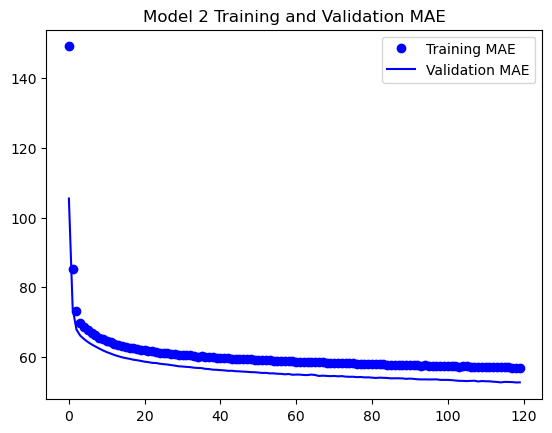

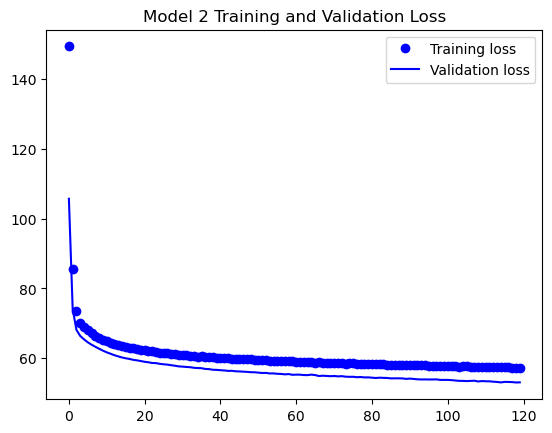

In [94]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model2_mae = model2_nn_histoire.history['mae']
model2_val_mae = model2_nn_histoire.history['val_mae']
model2_loss = model2_nn_histoire.history['loss']
model2_val_loss = model2_nn_histoire.history['val_loss']
model2_epochs = range(len(model2_mae))

plt.plot(model2_epochs, model2_mae, 'bo', label = 'Training MAE')
plt.plot(model2_epochs, model2_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 2 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model2_epochs, model2_loss, 'bo', label = 'Training loss')
plt.plot(model2_epochs, model2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.show();

In [95]:
model2_nn_train_preds = model2_nn.predict(model2_X_train_scaled)
model2_nn_test_preds = model2_nn.predict(model2_X_test_scaled)

2022-12-31 16:18:27.505004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [96]:
print(f'Model 2 train MAE w/ preds {mean_absolute_error(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 test MAE w/ preds {mean_absolute_error(model2_y_test.values, model2_nn_test_preds)}')

print(f'Model 2 explained variance train score {explained_variance_score(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 explained variance test score {explained_variance_score(model2_y_test.values, model2_nn_test_preds)}')

print(f'Model 2 test RMSE {mean_squared_error(model2_y_test.values, model2_nn_test_preds, squared = False)}')

Model 2 train MAE w/ preds 52.682734052839606
Model 2 test MAE w/ preds 52.69936912050986
Model 2 explained variance train score 0.6394055450639407
Model 2 explained variance test score 0.6372590728881757
Model 2 test RMSE 85.22893016809832


In [97]:
# best_model2_nn_model = load_model('austin_model2.h5')
# best_model2_nn_y_test_pred = best_model2_nn_model.predict(model2_X_test_scaled)
# print(mean_squared_error(best_y_test_pred, y_test))
# print(mean_squared_error(best_y_test_pred, y_test, squared = False))
# print(mean_absolute_error(best_y_test_pred, y_test))

## Model 3 - Random Forest

In [98]:
import time 

In [99]:
%%time

model3_X = austin_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model3_y = austin_modeling_data['daily_price']

model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.2)

model3_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

model3_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model3_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model3_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model3_nominal_pipeline, model3_nominal_cols ),
                        ('numpipe', model3_numeric_pipeline, model3_numeric_cols)])

model3_final_pipe = Pipeline([('preprocess', ct),
                              ('model', RandomForestRegressor())])

model3_results = model3_final_pipe.fit(model3_X_train, model3_y_train)

CPU times: user 6min 5s, sys: 2.45 s, total: 6min 7s
Wall time: 6min 8s


Model 3 train accuracy 0.9967910137538337
Model 3 train MSE 7.900805978052868
Model 3 train MAE 1.8862425369671523


Model 3 test accuracy 0.9814995478845249
Model 3 test MSE 18.9498915289104
Model 3 test MAE 4.799439960793122


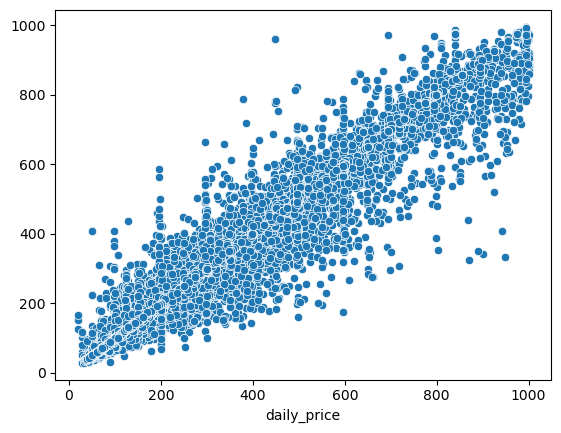

In [100]:
model3_train_preds = model3_final_pipe.predict(model3_X_train)
model3_test_preds = model3_final_pipe.predict(model3_X_test)

print(f'Model 3 train accuracy {model3_final_pipe.score(model3_X_train, model3_y_train)}')
print(f'Model 3 train MSE {mean_squared_error(model3_y_train, model3_train_preds, squared = False)}')
print(f'Model 3 train MAE {mean_absolute_error(model3_y_train, model3_train_preds)}')
print(f'\n')
print(f'Model 3 test accuracy {model3_final_pipe.score(model3_X_test, model3_y_test)}')
print(f'Model 3 test MSE {mean_squared_error(model3_y_test, model3_test_preds, squared = False)}')
print(f'Model 3 test MAE {mean_absolute_error(model3_y_test, model3_test_preds)}')

sns.scatterplot(y = model3_test_preds, x = model3_y_test);

In [101]:
# model3_coeffs = dict(zip(model3_final_pipe['preprocess'].get_feature_names_out(), 
#                                  model3_final_pipe['model'].feature_importances_))
# model3_coeffs = sorted(model3_coeffs.items(), key = lambda x:x[1])
# model3_coeffs

## Model 4 - Random Forest GridSearch

In [102]:
model4_X = austin_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model4_y = austin_modeling_data['daily_price']

model4_X_train, model4_X_test, model4_y_train, model4_y_test = train_test_split(model4_X, 
                                                                                model4_y, 
                                                                                test_size = 0.2)

model4_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_biltmore', 'distance_to_downtown']

model4_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model4_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model4_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model4_nominal_pipeline, model4_nominal_cols ),
                        ('numpipe', model4_numeric_pipeline, model4_numeric_cols)])

model4_final_pipe = Pipeline([('preprocess', ct),
                              ('rf', RandomForestRegressor(min_samples_leaf = 23,
                                                          max_depth = 23,
                                                           min_samples_split = 23))])

# model4_param_range = [1, 2, 3, 4, 5, 6]
                     
# model4_rf_param_grid = [{'rf__min_samples_leaf': model4_param_range,
#                          'rf__max_depth': model4_param_range,
#                          'rf__min_samples_split': model4_param_range[1:]}]
                     
# model4_rf_grid_search = GridSearchCV(estimator = model4_final_pipe,
#                                      param_grid = model4_rf_param_grid,
#                                      scoring = 'explained_variance',
#                                      cv = 3,
#                                      n_jobs = -10)
                     
# model4_rf_grid_search.fit(model4_X_train, model4_y_train)
model4_final_pipe.fit(model4_X_train, model4_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['neighborhood', 'room_type',
                                                   'day_of_week', 'month',
                                                   'week']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'Air conditioning', 'Wifi',
                                                   'TV', 'Kitchen', 'Washer',
                                                   'Dryer', 'Heating',
                                                   'distance_to_biltmore',
                                                   'distance_to_downtown'])])),
                ('rf',
                 RandomForestRegressor(max_depth=23, min_samples_leaf=23,
                                       min_samples_split=23))])

Model 4 train accuracy 0.9467273546071585
Model 4 train MSE 32.2032299498181
Model 4 train MAE 13.628075913475552


Model 4 test accuracy 0.9436166105124676
Model 4 test MSE 33.03306830880385
Model 4 test MAE 13.976587740677546


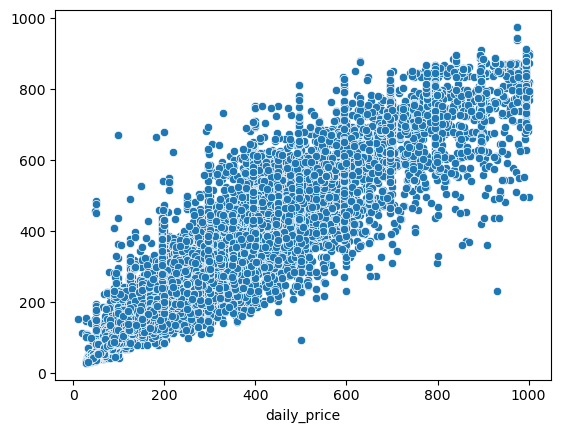

In [103]:
model4_train_preds = model4_final_pipe.predict(model4_X_train)
model4_test_preds = model4_final_pipe.predict(model4_X_test)

print(f'Model 4 train accuracy {model4_final_pipe.score(model4_X_train, model4_y_train)}')
print(f'Model 4 train MSE {mean_squared_error(model4_y_train, model4_train_preds, squared = False)}')
print(f'Model 4 train MAE {mean_absolute_error(model4_y_train, model4_train_preds)}')
print(f'\n')
print(f'Model 4 test accuracy {model4_final_pipe.score(model4_X_test, model4_y_test)}')
print(f'Model 4 test MSE {mean_squared_error(model4_y_test, model4_test_preds, squared = False)}')
print(f'Model 4 test MAE {mean_absolute_error(model4_y_test, model4_test_preds)}')

sns.scatterplot(y = model4_test_preds, x = model4_y_test);

## Testing Predictions

In [114]:
host_superhost = input('Host is Superhost (Y/N): ')
room_type = input('Room Type (Entire home/apt or Private room)')
accommodates = input('Accomodates (1-16) Guests: ')
num_of_bedrooms = input('Number of Bedrooms: ')
num_of_beds = input('Number of Beds: ')
select_neighborhood = input('Neighborhood (Asheville/Candler/Fletcher/Woodfin): ')
num_of_bathrooms = input('Number of Bathrooms: ')
check_AC = input('AC (Y/N): ')
check_wifi = input('Wifi (Y/N): ')
check_TV = input('TV (Y/N): ')
check_kitchen = input('Kitchen (Y/N): ')
check_washer = input('Washer (Y/N): ')
check_dryer = input('Dryer (Y/N): ')
check_heating = input('Heating (Y/N): ')
select_latitude = input('Latitude: ')
select_longitude = input('Longitude: ')
checkin_date = input('Check-in Date: ')
checkout_date = input('Check-out Date: ')


Host is Superhost (Y/N): Y
Room Type (Entire home/apt or Private room)Entire home/apt
Accomodates (1-16) Guests: 2
Number of Bedrooms: 2
Number of Beds: 2
Neighborhood (Asheville/Candler/Fletcher/Woodfin): Asheville
Number of Bathrooms: 2
AC (Y/N): Y
Wifi (Y/N): Y
TV (Y/N): Y
Kitchen (Y/N): Y
Washer (Y/N): Y
Dryer (Y/N): Y
Heating (Y/N): Y
Latitude: 20
Longitude: -20
Check-in Date: 1/1/2023
Check-out Date: 12/1/2023


In [115]:
def yes_no_conversion(input):
    if input == 'Y':
        return 1
    else:
        return 0

In [117]:
conv_long = float(select_longitude)
conv_lat = float(select_latitude)
test_coords = list((conv_lat, conv_long))
predicted_checkin_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkin_date).dayofweek,
                          pd.to_datetime(checkin_date).month,
                          pd.to_datetime(checkin_date).week]
#may need to reshape with 1, -1 for actual prediction or .to_frame()

In [118]:
checkin_prediction_df = pd.DataFrame(predicted_checkin_list).T
checkin_prediction_df = checkin_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_biltmore',
                                      16: 'distance_to_downtown',
                                      17: 'day_of_week',
                                      18: 'month',
                                      19: 'week'}, axis = 1)

checkin_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,coords,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
0,1,Entire home/apt,2,2,2,Asheville,2,1,1,1,1,1,1,1,"[20.0, -20.0]",3912.65183,3912.128241,6,1,52


In [122]:
predicted_checkout_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, biltmore).miles,
                          geodesic(test_coords, downtown).miles,
                          pd.to_datetime(checkout_date).dayofweek,
                          pd.to_datetime(checkout_date).month,
                          pd.to_datetime(checkout_date).week]
#may need to reshape with 1, -1 for actual prediction or .to_frame()

In [123]:
checkout_prediction_df = pd.DataFrame(predicted_checkout_list).T
checkout_prediction_df = checkout_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_biltmore',
                                      16: 'distance_to_downtown',
                                      17: 'day_of_week',
                                      18: 'month',
                                      19: 'week'}, axis = 1)

checkout_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,coords,distance_to_biltmore,distance_to_downtown,day_of_week,month,week
0,1,Entire home/apt,2,2,2,Asheville,2,1,1,1,1,1,1,1,"[20.0, -20.0]",3912.65183,3912.128241,4,12,48


In [124]:
print(f'${float(model3_final_pipe.predict(checkout_prediction_df))} per night')
print(f'${float(model3_final_pipe.predict(checkin_prediction_df))} per night')

$290.59 per night
$270.0 per night


In [125]:
#XGBoost, rf gridsearch
    #save the models and use for other data/preprocess

In [ ]:
#Creating a .py file - here will need all the parameters the function will use